In this project I will try to suggest optimal locations to open a new **Asian Restaurant in Delhi, India**. 

Since there are a lot of restaurants in Delhi we will try to locate **Neighbourhoods which are not crowded with Indian Restaurants** and have a lower density of India Restaurants. We will also try to make recommendations which are near Famous Spots of the city. 

We will use Data Science to analyse the data and make recommendations based on the neighbourhoods that suit the criteria stated above. We will return a list of the recommendations in the order of their distances from the most popular Neighbourhoods.

## Data <a name="data"></a>

Based on our problem, factors that will influence our decision are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of Indian restaurants in the neighborhood
* distance of neighborhood from Popular Spots


Following data sources will be needed to extract/generate the required information:
* **Wikipedia page** will be scraped for Borough and Neighbourhood details of Delhi.
* Coordinates of the neighbourhoods scraped above will be obtained using **Geopy**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from geopy.geocoders import Nominatim
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

import matplotlib.colors as colors
import seaborn as sns

### Scraping the Wikipedia Page
We will scrape the Wikipedia <a href='https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi'>page</a> of Neighbourhoods of Delhi for the Borough and Neighbourhood data. 

In [2]:
url = 'https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi'
# Get the page using Requests
r = requests.get(url).text
soup = BeautifulSoup(r,'lxml')

In [3]:
div = soup.find('div',class_='mw-parser-output')
print(div)

<div class="mw-parser-output"><p class="mw-empty-elt">
</p>
<div class="thumb tright"><div class="thumbinner" style="width:302px;"><a class="image" href="/wiki/File:Delhi_districts.svg"><img alt="" class="thumbimage" data-file-height="3011" data-file-width="3184" decoding="async" height="284" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Delhi_districts.svg/300px-Delhi_districts.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Delhi_districts.svg/450px-Delhi_districts.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Delhi_districts.svg/600px-Delhi_districts.svg.png 2x" width="300"/></a> <div class="thumbcaption"><div class="magnify"><a class="internal" href="/wiki/File:Delhi_districts.svg" title="Enlarge"></a></div>Map showing the nine <a class="mw-redirect" href="/wiki/Districts_of_Delhi" title="Districts of Delhi">districts</a> of Delhi.</div></div></div>
<p><a href="/wiki/Delhi" title="Delhi">Delhi</a> is a vast city and is home to a p

### Create a dataframe from the scraped information
We will use the information scraped using BeautifulSoup to create the DataFrame which we can use in the project.

In [4]:
data = pd.DataFrame(columns=['Borough','Neighbourhood'])
i = -1
no = 0
flag = False
for child in div.children:
    if child.name:
        span = child.find('span')
        if span!=1 and span is not None:
            try: 
                if span['class'][0] == 'mw-headline' and child.a.text!='edit':
                    borough = child.a.text
                    i+=1
                    flag = True
                    continue
            except KeyError:
                continue
                
        if child.name=='ul' and flag==True:
            neighbourhood = []
            for ch in child.children:
                try:
                    data.loc[no]=[borough,ch.text]
                    no+=1
                except AttributeError:
                    pass
        flag = False
data.head()

,Borough,Neighbourhood
0,North West Delhi,Adarsh Nagar
1,North West Delhi,Ashok Vihar
2,North West Delhi,Begum Pur
3,North West Delhi,Karala
4,North West Delhi,Model Town


### Using Geopy API to get location data for each of the Neighbourhoods
The Neighbourhood data scraped above can be used to obtain the coordinates of all Neighbourhoods using Geopy.

In [5]:
lat_lng = pd.DataFrame(columns=['Neighbourhood','latitude','longitude'])
geolocator = Nominatim(user_agent="ny_explorer")
for i in range(113):
    address = data['Neighbourhood'].loc[i]+',New Delhi'
    try: 
        location = geolocator.geocode(address)
        lat_lng.loc[i]=[data['Neighbourhood'].loc[i],location.latitude,location.longitude]
    except AttributeError:
        continue
        


In [6]:
data = pd.merge(data,lat_lng,on='Neighbourhood',suffixes=[False,False])
data

,Borough,Neighbourhood,latitude,longitude
0,North West Delhi,Adarsh Nagar,28.614193,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Karala,28.735140,77.032511
3,North West Delhi,Model Town,28.641926,77.221750
4,North West Delhi,Narela,28.842610,77.091835
...,...,...,...,...
97,West Delhi,Patel Nagar,28.659809,77.156957
98,West Delhi,Punjabi Bagh,28.668945,77.132461
99,West Delhi,Rajouri Garden,28.642152,77.116060
100,West Delhi,Tilak Nagar,28.636548,77.096496


### Using Geopy API to get location data for the city of New Delhi
Coordinates of the city can be obtained using Geolocator 

In [7]:
address = 'New Delhi'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of New Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of New Delhi are 28.6138954, 77.2090057.


### Visualize the Neighbourhoods in the city of Delhi
Let's display the neighbourhoods of Delhi on a map using Folium

In [8]:
delhidf = data
delhi_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(delhidf['latitude'], delhidf['longitude'], delhidf['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(delhi_map)
delhi_map

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category. So we will set the categoy ID accordingly which can be found in Foursquare.

Foursquare Credentials will be needed while running this step. 

In [9]:
CLIENT_ID = '#####'
CLIENT_SECRET = '#####'
VERSION = '20180605'
LIMIT = 100

### Function to extract details of nearby Venues using Foursquare API


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            '4d4b7105d754a06374d81259',
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
delhi_venues = getNearbyVenues(names=delhidf['Neighbourhood'],
                                   latitudes=delhidf['latitude'],
                                   longitudes=delhidf['longitude']
                                  )

Adarsh Nagar
Ashok Vihar
Karala
Model Town
Narela
Pitam Pura
Shalimar Bagh
Civil Lines
Kamla Nagar
Kashmiri Gate
Kotwali
Mori Gate; Delhi
Sadar Bazaar
Sarai Rohilla
Shakti Nagar
Shastri Nagar.
Tis Hazari
Timarpur
Wazirabad
Dilshad Garden
Naveen Shahdara
Shahdara
Shastri Park
Yamuna Vihar
Chandni Chowk
Daryaganj
Jhandewalan
Karol Bagh
Kishanganj
Paharganj
Barakhamba Road
Chanakyapuri
Connaught Place
East Vinod Nagar
Jhilmil Colony
Laxmi Nagar
Mayur Vihar
Pandav Nagar
Preet Vihar
Anand Vihar
Vasundhara Enclave
Vishwas Nagar
Vivek Vihar
Alaknanda
Chittaranjan Park
Defence Colony
East of Kailash
Govindpuri
Greater Kailash
Green Park
Gulmohar Park
Hauz Khas
Hauz Khas Village
Jangpura
Jor Bagh
Kalkaji
Khanpur
Lajpat Nagar
Lodi Colony
Malviya Nagar
Mehrauli
Neeti Bagh
Nehru Place
Netaji Nagar
New Friends Colony
Nizamuddin West
Okhla
Safdarjung Enclave
Sainik Farm
Saket
Sangam Vihar
Sarita Vihar
Sarojini Nagar
Sarvodaya Enclave
Siri Fort
South Extension
Sriniwaspuri
Tughlaqabad
Badarpur
Delhi 

In [12]:
delhi_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,28.614193,77.071541,Eagle Boys Pizza,28.615595,77.070784,Pizza Place
1,Adarsh Nagar,28.614193,77.071541,Bikanerwala,28.613391,77.076084,Indian Restaurant
2,Adarsh Nagar,28.614193,77.071541,Bikano East Patel Nagar,28.616190,77.066978,Fast Food Restaurant
3,Adarsh Nagar,28.614193,77.071541,McDonald's,28.616330,77.067034,Fast Food Restaurant
4,Ashok Vihar,28.699453,77.184826,Nat Khat Caterers,28.699630,77.187832,Indian Restaurant
...,...,...,...,...,...,...,...
519,Tilak Nagar,28.636548,77.096496,Bikanerwala,28.633524,77.097492,Fast Food Restaurant
520,Vikaspuri,28.638419,77.070836,Domino's Pizza,28.638000,77.075000,Pizza Place
521,Vikaspuri,28.638419,77.070836,McDonald's,28.639752,77.075190,Fast Food Restaurant
522,Vikaspuri,28.638419,77.070836,Asian Garden,28.639661,77.074482,Indian Restaurant


### Visualizing the various venues across the city of Delhi
Various results from the Foursquare API can be displayed on a map using folium. Since folium leaflet doesn't render when there are a lot of markers. The limit of markers which can be rendered properly fall around at 200. So for that reason we will display the first 200 venues.

In [13]:
map_ven = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(delhi_venues['Venue Latitude'].loc[range(210)], delhi_venues['Venue Longitude'].loc[range(210)], delhi_venues['Venue'].loc[range(210)]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1.5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ven)  
    
map_ven

## Methodology <a name="methodology"></a>

In this project we will try to recommend the Neighbourhoods with lower densities of food category venues and lower densities of Indian Restaurants. 

We will also rank our recommendations based on the distance of those Neighbourhoods from the top 3 popular parts of the city. 

In the first step we will tranform the data to have Neighbourhoods in the rows section and the type of food category venues as columns. We group this data based on Neighbourhood and will transform the data to reflect the 10 most common type of food category venues for reach Neighbourhood.

In the second step we will apply KMeans Clustering Algorithm to the data to create Neighbourhood Clusters. Each cluster will have Neighbourhoods with similar features in terms of the type of food venues available there. We will analyse the results and choose the cluster with highest demand for Indian Restaurants. Then the most dense areas are removed from the candidature. Dense regions are generally saturated to a lot of extent and new businesses tend to not do well.

In the third step we will make recommendations of best suited Neighbourhoods and rank them based on their distance from the most popular places of Delhi. We will also visualize our recommended locations on a map using Folium.



## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First lets transform our data to show Type of Food Venue as columns and Neighbourhoods as rows.

In [14]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighbourhood'] = delhi_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

delhi_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,...,Snack Place,South Indian Restaurant,Steakhouse,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashok Vihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
delhi_onehot.shape

(524, 65)

Let's **group the dataframe** obtained by Neighbourhood so that there are no two rows for any Neighbourhood. We count the values across columns accordingly.

In [16]:
#To be used while Generating Graphs
delhi_grouped = delhi_onehot.groupby('Neighbourhood').mean().reset_index()
delhi_grouped.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,...,Snack Place,South Indian Restaurant,Steakhouse,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Adarsh Nagar,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaknanda,0.0,0.0,0.0,0.0,0.222222,0.0,0.00,0.0,0.0,...,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anand Vihar,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashok Nagar,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ashok Vihar,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
for i in delhi_grouped.columns:
    print(i,end=", ")

Neighbourhood, Afghan Restaurant, American Restaurant, Asian Restaurant, Awadhi Restaurant, BBQ Joint, Bagel Shop, Bakery, Bistro, Breakfast Spot, Burger Joint, Cafeteria, Café, Chinese Restaurant, Comfort Food Restaurant, Deli / Bodega, Dhaba, Dim Sum Restaurant, Diner, Doner Restaurant, Donut Shop, Dumpling Restaurant, Falafel Restaurant, Fast Food Restaurant, Fish & Chips Shop, Food, Food Court, Food Truck, French Restaurant, Fried Chicken Joint, Gastropub, Hot Dog Joint, Hyderabadi Restaurant, Indian Chinese Restaurant, Indian Restaurant, Indian Sweet Shop, Italian Restaurant, Japanese Restaurant, Mediterranean Restaurant, Mexican Restaurant, Middle Eastern Restaurant, Modern European Restaurant, Molecular Gastronomy Restaurant, Mughlai Restaurant, Multicuisine Indian Restaurant, New American Restaurant, North Indian Restaurant, Parsi Restaurant, Pizza Place, Portuguese Restaurant, Punjabi Restaurant, Rajasthani Restaurant, Restaurant, Sandwich Place, Scandinavian Restaurant, Snack

In [18]:
delhi_grouped.shape

(91, 65)

We sort the data and keep the **10 most common type of food venues** for each Neighbourhood. 

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = delhi_grouped['Neighbourhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Fast Food Restaurant,Pizza Place,Indian Restaurant,Dhaba,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
1,Alaknanda,BBQ Joint,Indian Restaurant,New American Restaurant,Restaurant,Pizza Place,Steakhouse,Middle Eastern Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant
2,Anand Vihar,Pizza Place,Indian Restaurant,Fast Food Restaurant,Dhaba,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
3,Ashok Nagar,Fast Food Restaurant,Food Court,Chinese Restaurant,Wings Joint,Dim Sum Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food
4,Ashok Vihar,Indian Restaurant,Bakery,Diner,Wings Joint,Dim Sum Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food
...,...,...,...,...,...,...,...,...,...,...,...
86,Vikaspuri,Indian Restaurant,Pizza Place,Fast Food Restaurant,Dhaba,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
87,Vishwas Nagar,Indian Restaurant,Café,Wings Joint,Dim Sum Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
88,Vivek Vihar,Japanese Restaurant,Wings Joint,Hot Dog Joint,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant
89,Wazirabad,Snack Place,Wings Joint,Dhaba,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant


### Applying the Clustering Algorithm
We apply KMeans Clustering Algorithm to the data to cluster the Neighbourhoods on basis of the most common type of food venues across each Neighbourhood.

In [21]:
# set number of clusters
kclusters = 5

delhi_grouped_clustering = delhi_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 0, 1, 0, 0, 4, 0, 2, 1])

In [22]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = delhidf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

delhi_merged.dropna(inplace=True)
delhi_merged

,Borough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,28.614193,77.071541,1.0,Fast Food Restaurant,Pizza Place,Indian Restaurant,Dhaba,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
1,North West Delhi,Ashok Vihar,28.699453,77.184826,0.0,Indian Restaurant,Bakery,Diner,Wings Joint,Dim Sum Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food
3,North West Delhi,Model Town,28.641926,77.221750,1.0,Fast Food Restaurant,Food Court,Chinese Restaurant,Wings Joint,Dim Sum Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food
5,North West Delhi,Pitam Pura,28.703268,77.132250,0.0,Indian Restaurant,Fried Chicken Joint,Bakery,Wings Joint,Dim Sum Restaurant,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
6,North West Delhi,Shalimar Bagh,28.717453,77.150867,4.0,Dumpling Restaurant,Wings Joint,Vegetarian / Vegan Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,West Delhi,Patel Nagar,28.659809,77.156957,3.0,Café,Wings Joint,Dim Sum Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food,Fish & Chips Shop
98,West Delhi,Punjabi Bagh,28.668945,77.132461,1.0,Fast Food Restaurant,Bakery,Pizza Place,Sandwich Place,Breakfast Spot,Food Court,Food,Food Truck,Fish & Chips Shop,Dhaba
99,West Delhi,Rajouri Garden,28.642152,77.116060,4.0,Indian Restaurant,BBQ Joint,Food Truck,Bakery,Wings Joint,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Falafel Restaurant
100,West Delhi,Tilak Nagar,28.636548,77.096496,1.0,Fast Food Restaurant,Café,Wings Joint,Dim Sum Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food


<h3>Visualizing the Clusters</h3>

In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['latitude'], delhi_merged['longitude'], delhi_merged['Neighbourhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysis of Cluster Data
Let's analyse how our clusters look like in terms of the type of food venues

In [24]:
clusterdata = pd.merge(delhi_onehot.groupby('Neighbourhood').sum(),delhi_merged[['Neighbourhood','Cluster Labels']],left_on='Neighbourhood', right_on='Neighbourhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata

Cluster Labels,0.0,1.0,2.0,3.0,4.0
Afghan Restaurant,0,0,0,0,1
American Restaurant,1,1,0,0,2
Asian Restaurant,2,0,0,0,11
Awadhi Restaurant,0,0,0,0,1
BBQ Joint,0,0,0,0,14
...,...,...,...,...,...
Theme Restaurant,0,0,0,0,1
Tibetan Restaurant,0,1,0,0,1
Turkish Restaurant,0,0,0,0,1
Vegetarian / Vegan Restaurant,1,0,0,0,3


### Visualizing the clusters using Bar Graphs

In [25]:
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

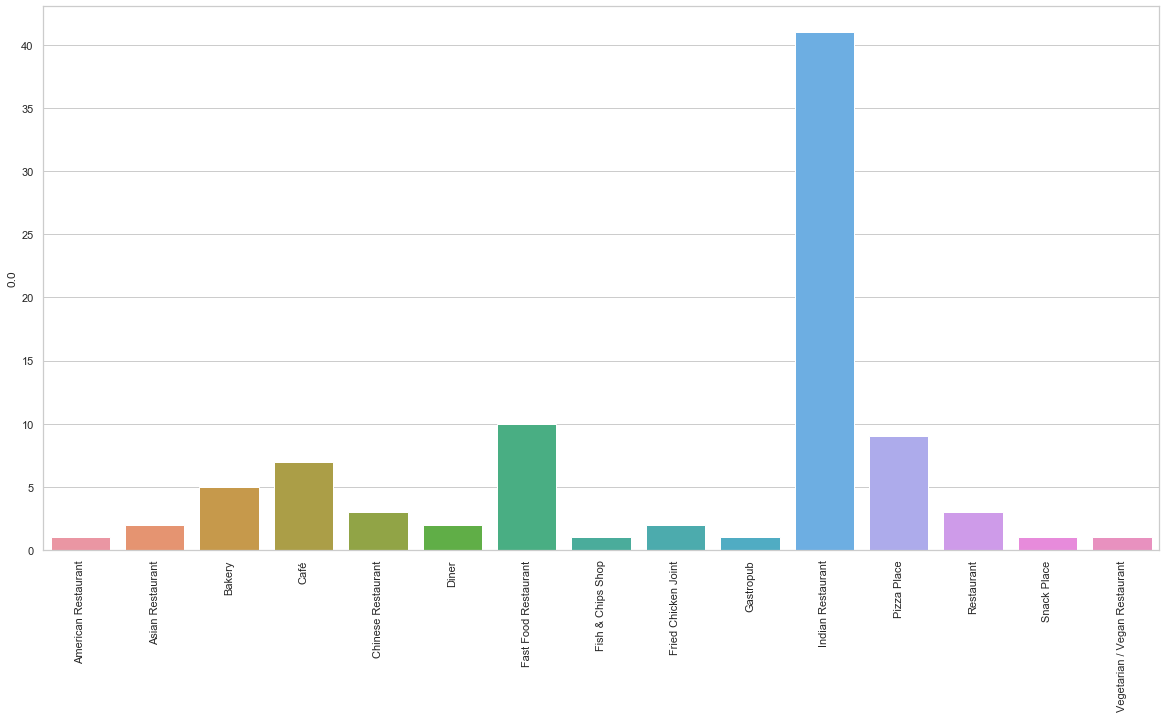

In [26]:
plot_bar(0)

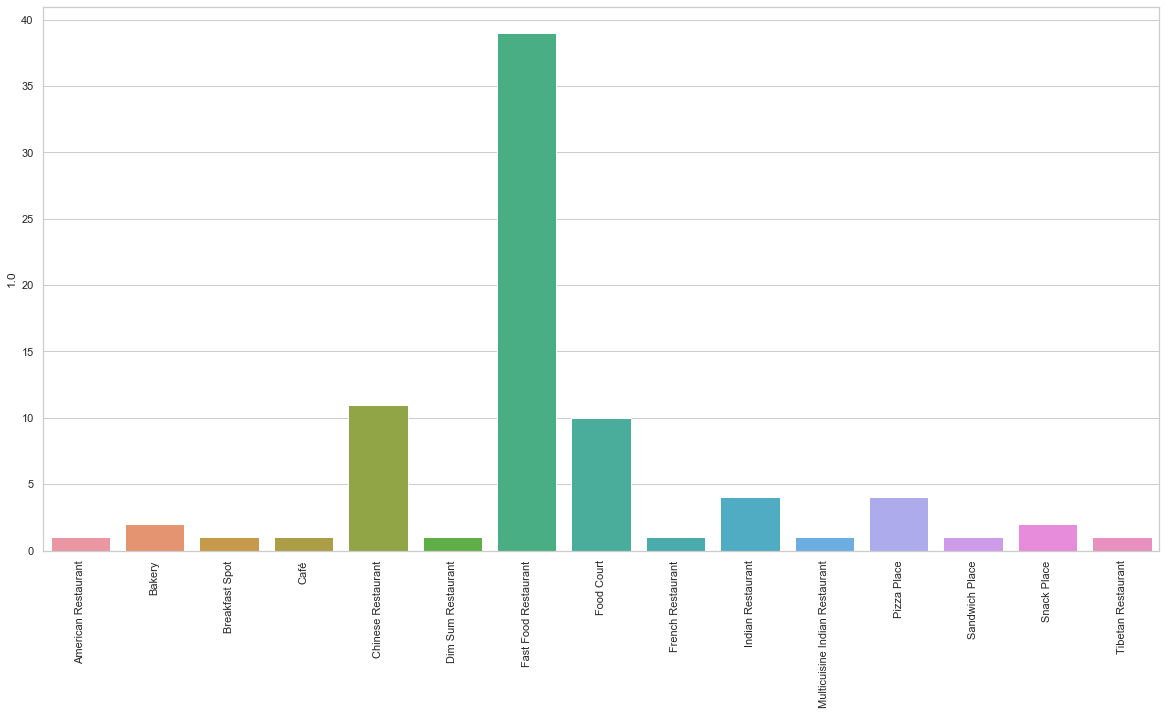

In [27]:
plot_bar(1)

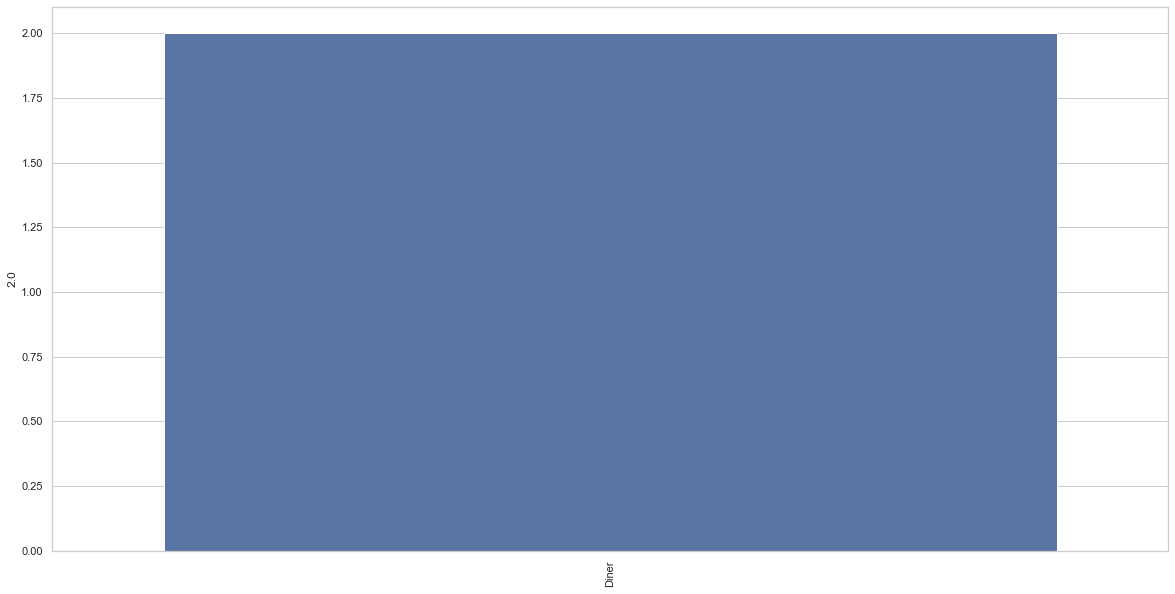

In [28]:
plot_bar(2)

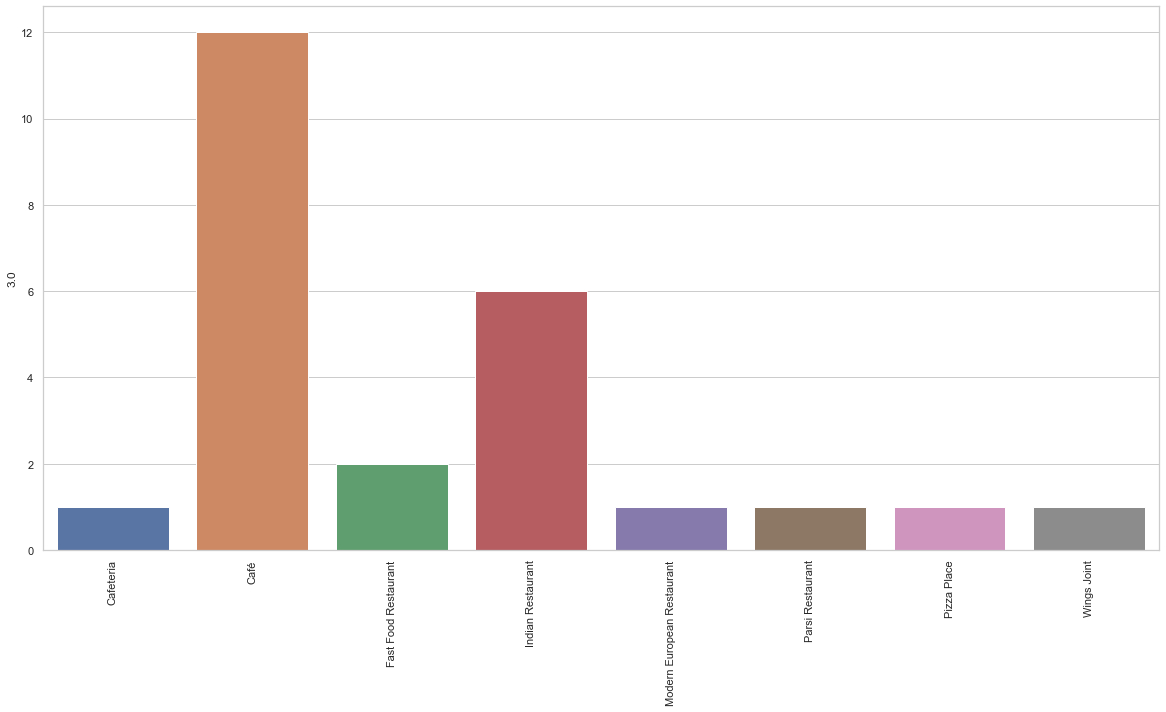

In [29]:
plot_bar(3)

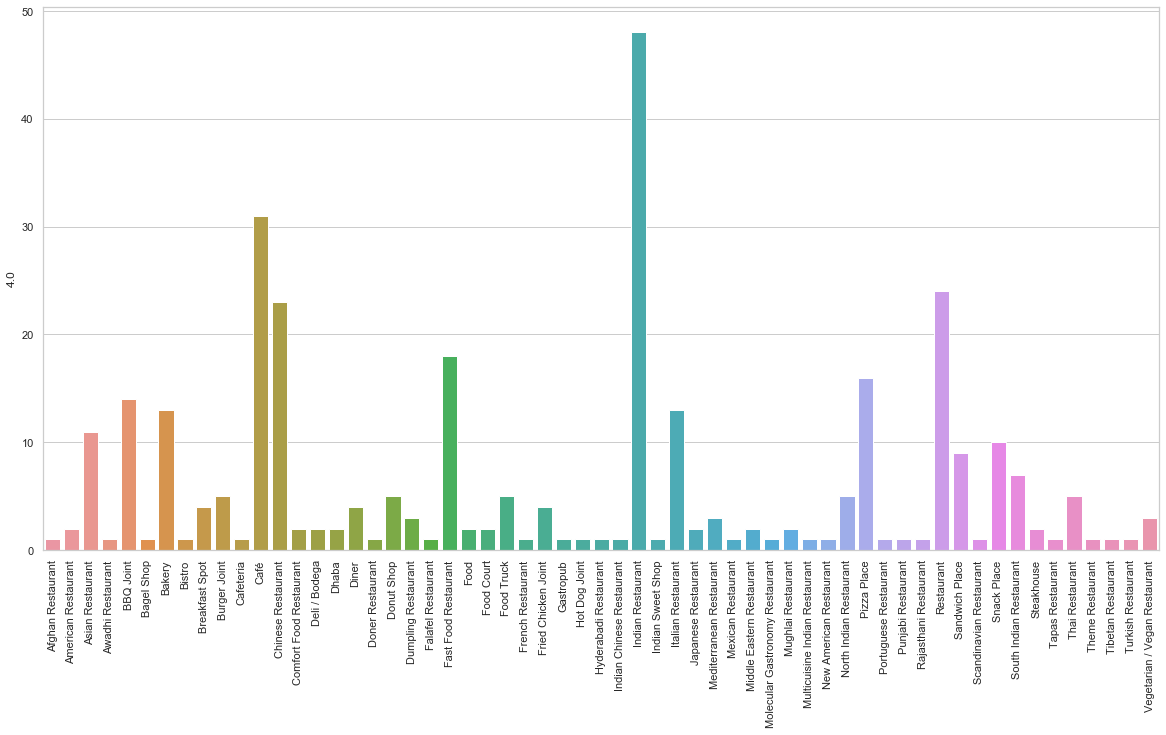

In [30]:
plot_bar(4)

<h3>Analysis of the bar graphs clearly show that clusters 0 and 2 have a high demand for Indian Restaurants</h3>

In [31]:
forheatmap=delhi_venues.copy()
forheatmap=pd.merge(forheatmap,delhi_merged[['Neighbourhood','Cluster Labels']],left_on='Neighbourhood', right_on='Neighbourhood',how='inner')
forheatmap.drop(forheatmap[~forheatmap['Cluster Labels'].isin([0,2])].index, inplace=True)

In [32]:
forheatmap.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
4,Ashok Vihar,28.699453,77.184826,Nat Khat Caterers,28.699630,77.187832,Indian Restaurant,0.0
5,Ashok Vihar,28.699453,77.184826,Bakers Stop,28.700495,77.188716,Bakery,0.0
6,Ashok Vihar,28.699453,77.184826,Invitation Banquet,28.696018,77.185953,Diner,0.0
7,Ashok Vihar,28.699453,77.184826,Gola Northend,28.701242,77.189288,Indian Restaurant,0.0
12,Pitam Pura,28.703268,77.132250,Angrezee Dhaba,28.702592,77.133812,Indian Restaurant,0.0


### Visualizing the clusters with high demand for Indian Restaurants
Let's visualize the top two clusters with relatively higher demand for Indian Restaurants

In [33]:
from folium.plugins import HeatMap

In [34]:
#heat map of all restaurants in selected Neighborhoods
res_heat = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forheatmap['Venue Latitude'],forheatmap['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat)
for lat, lng, label in zip(forheatmap['Neighbourhood Latitude'], forheatmap['Neighbourhood Longitude'], forheatmap['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat)
res_heat

### Visualizing the Indian Restaurants in the 2 clusters with high demand for Indian Restaurants
Let's remove the other types of food venue and visualize the Indian Restaurants' heat-map for the Neighbourhoods with highest demand for Indian Restaurants

In [35]:
forindres = forheatmap[forheatmap['Venue Category']=='Indian Restaurant']

# heat map for Indian Restaurants in the selected Neighborhoods
res_heat_ind = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forindres['Venue Latitude'],forindres['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat_ind)
for lat, lng, label in zip(forindres['Neighbourhood Latitude'], forindres['Neighbourhood Longitude'], forindres['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat_ind)
res_heat_ind

Now we will remove all neighbourhoods with the following conditions:
<ul>
    <li>Number of Indian restaurants >30 percentile</li>
    <li>Number of all restaurants >60 percentile</li>
</ul>

In [36]:
count_all = forheatmap[['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(by='Venue')
target_count = int(0.6*len(count_all))
print(count_all.iloc[target_count])
count_all.drop(count_all[count_all.Venue.values>7].index,inplace=True)
count_all.columns=['all count']
count_all.head()

Venue    4
Name: Ashok Vihar, dtype: int64


,all count
Neighbourhood,
Palam,1
Chanakyapuri,1
East Vinod Nagar,1
Inderpuri,2
Badarpur,2


In [37]:
count_ind = forheatmap[forheatmap['Venue Category']=="Indian Restaurant"][['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(by='Venue')
target_count = int(0.3*len(count_ind))
print(count_ind.iloc[target_count])
count_ind.drop(count_ind[count_ind.Venue.values>1].index,inplace=True)
count_ind.columns = ['ind count']
count_ind.head()

Venue    2
Name: Pitam Pura, dtype: int64


,ind count
Neighbourhood,
Anand Vihar,1
Badarpur,1
Palam,1
Sriniwaspuri,1
Inderpuri,1


## Recommendations
Let's see the names of Neighbourhoods that are left after removing the densely populated in terms of Food venues and Indian restaurants Neighbourhoods

In [38]:
lowdensity = count_all.join(count_ind)
lowdensity.index.values

array(['Palam', 'Chanakyapuri', 'East Vinod Nagar', 'Inderpuri',
       'Badarpur', 'Khanpur', 'Green Park', 'Anand Vihar',
       'Gulmohar Park', 'Sriniwaspuri', 'Jhandewalan', 'Karol Bagh',
       'Ashok Vihar', 'Pitam Pura', 'Vikaspuri', 'Daryaganj',
       'Jhilmil Colony', 'Barakhamba Road'], dtype=object)

In [39]:
temp_recommend = delhidf.copy()
temp_recommend.drop(temp_recommend[~temp_recommend['Neighbourhood'].isin(lowdensity.index.values)].index, inplace=True)
temp_recommend.head()

,Borough,Neighbourhood,latitude,longitude
1,North West Delhi,Ashok Vihar,28.699453,77.184826
5,North West Delhi,Pitam Pura,28.703268,77.132250
25,Central Delhi,Daryaganj,28.646090,77.243048
26,Central Delhi,Jhandewalan,28.644319,77.199917
27,Central Delhi,Karol Bagh,28.652998,77.189023


<h3>Since the restaurant needs to be near a popular neighbourhood, we will add another constraint</h3>

In [40]:
#most popular neighborhoods
top_nei = delhi_venues[['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(by='Venue', ascending=False).head(3).index.values
top_nei

array(['Connaught Place', 'Hauz Khas Village', 'Defence Colony'],
      dtype=object)

In [41]:
toplatlng = delhidf[['Neighbourhood','latitude','longitude']][delhidf['Neighbourhood'].isin(top_nei)].reset_index()
toplatlng

,index,Neighbourhood,latitude,longitude
0,32,Connaught Place,28.631383,77.219792
1,45,Defence Colony,28.571222,77.231776
2,52,Hauz Khas Village,28.553855,77.194713


Funcation to calculate Mathematically the distance between locations

In [42]:
from math import sin, cos, sqrt, atan2, radians

def distanceInKM(la1,lo1,la2,lo2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dis = R * c
    return round(dis,4)

print("Result:", distanceInKM(toplatlng.iloc[2]['latitude'],toplatlng.iloc[2]['longitude'],toplatlng.iloc[0]['latitude'],toplatlng.iloc[0]['longitude']))

Result: 8.9645


In [43]:
temp_recommend.reset_index(inplace=True)

In [44]:
temp_recommend.drop(columns=['index','Borough'], inplace=True)

In [45]:
temp_recommend.head()

,Neighbourhood,latitude,longitude
0,Ashok Vihar,28.699453,77.184826
1,Pitam Pura,28.703268,77.132250
2,Daryaganj,28.646090,77.243048
3,Jhandewalan,28.644319,77.199917
4,Karol Bagh,28.652998,77.189023


Let's see the recommendations' distances from each of the popular spot of Delhi

In [46]:
for i in toplatlng.index:
    temp_recommend[toplatlng.iloc[i]['Neighbourhood']] = temp_recommend.apply(lambda x : distanceInKM(toplatlng.iloc[i]['latitude'],toplatlng.iloc[i]['longitude'],x['latitude'],x['longitude']),axis=1)

In [47]:
temp_recommend.head()

,Neighbourhood,latitude,longitude,Connaught Place,Defence Colony,Hauz Khas Village
0,Ashok Vihar,28.699453,77.184826,8.3050,14.9816,16.2236
1,Pitam Pura,28.703268,77.132250,11.7016,17.6103,17.7027
2,Daryaganj,28.646090,77.243048,2.7982,8.4000,11.2931
3,Jhandewalan,28.644319,77.199917,2.4156,8.7055,10.0751
4,Karol Bagh,28.652998,77.189023,3.8474,10.0083,11.0417


In [48]:
# top 5 neighborhoods near Connaught Place
neiNearCP = temp_recommend.sort_values(by=['Connaught Place']).iloc[:,:3].head().set_index('Neighbourhood')
neiNearCP

,latitude,longitude
Neighbourhood,,
Barakhamba Road,28.626952,77.229950
Green Park,28.613895,77.209006
Jhandewalan,28.644319,77.199917
Daryaganj,28.646090,77.243048
Karol Bagh,28.652998,77.189023


In [49]:
# top 5 neighborhoods near Hauz Khas Village
neiNearHK = temp_recommend.sort_values(by=['Hauz Khas Village']).iloc[:,:3].head().set_index('Neighbourhood')
neiNearHK

,latitude,longitude
Neighbourhood,,
Gulmohar Park,28.557101,77.213005
Chanakyapuri,28.594677,77.188521
Khanpur,28.512798,77.232395
Sriniwaspuri,28.565220,77.254704
Green Park,28.613895,77.209006


In [50]:
# top 5 neighborhoods near Khirki Village
neiNearKV = temp_recommend.sort_values(by=['Defence Colony']).iloc[:,:3].head().set_index('Neighbourhood')
neiNearKV

,latitude,longitude
Neighbourhood,,
Sriniwaspuri,28.565220,77.254704
Gulmohar Park,28.557101,77.213005
Chanakyapuri,28.594677,77.188521
Green Park,28.613895,77.209006
Barakhamba Road,28.626952,77.229950


## Final Recommendation
Let's rank and display the top recommended Neighbourhoods to open a new Indian Restaurant based on a higher demand for Indian Food and a lower density of already existing competition.

In [51]:
final_recommend=neiNearCP.append(neiNearHK).append(neiNearKV).reset_index()
final_recommend.drop_duplicates(inplace=True)
final_recommend.reset_index(inplace=True)
final_recommend.drop(columns=['index'],inplace=True)
final_recommend

,Neighbourhood,latitude,longitude
0,Barakhamba Road,28.626952,77.229950
1,Green Park,28.613895,77.209006
2,Jhandewalan,28.644319,77.199917
3,Daryaganj,28.646090,77.243048
4,Karol Bagh,28.652998,77.189023
5,Gulmohar Park,28.557101,77.213005
6,Chanakyapuri,28.594677,77.188521
7,Khanpur,28.512798,77.232395
8,Sriniwaspuri,28.565220,77.254704


<h2>Visualizing the recommended Neighbourhoods</h2>

In [52]:
final = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(final_recommend['latitude'], final_recommend['longitude'], final_recommend['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(final)  
    
final